In [8]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from transformers import DebertaTokenizer, DebertaForSequenceClassification
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm
import zipfile
import pandas as pd
import numpy as np
import tensorflow as tf

In [10]:
def unzip_file(zip_filepath, dest_folder):
    with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
        zip_ref.extractall(dest_folder)

zip_file = '/content/drive/MyDrive/nlp-getting-started.zip'
destination_folder = '/content'

unzip_file(zip_file, destination_folder)

# Load the Disaster Tweets
Let's have a look at the train and test dataset.

They contain:
1.   id
2.   keyword: A keyword from that tweet (although this may be blank!)
3. location: The location the tweet was sent from (may also be blank)
4. text: The text of a tweet
5. target: 1 if the tweet is a real disaster or 0 if not



In [11]:
df_train = pd.read_csv("/content/train.csv")
df_test = pd.read_csv("/content/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


Some info about train and test data:

In [25]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [26]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      3263 non-null   int64
 1   target  3263 non-null   int64
dtypes: int64(2)
memory usage: 51.1 KB


Location feature seems to have a lot of missing values which why it is not going to be used fot the training.
Also, keywords seem to be broken or contain garbage information and it is also not going to be used later.

Class distributions are 57% for 0 (Not Disaster) and 43% for 1 (Disaster). Classes are almost equally separated so they don't require any resampling.

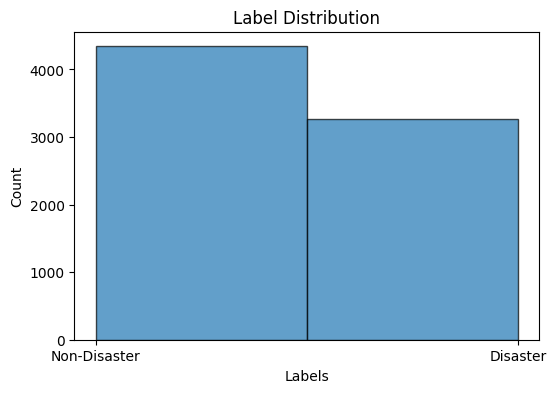

In [30]:
import matplotlib.pyplot as plt

# plot histogram of label distribution
def plot_label_dist(df):
    plt.figure(figsize=(6, 4))
    plt.hist(df['target'], bins=2, edgecolor='black', alpha=0.7)
    plt.xticks(np.arange(2), ['Non-Disaster', 'Disaster'])
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Label Distribution')
    plt.show()

plot_label_dist(df_train)

Splitting the data.

In [12]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = df_test["text"]

# Load a DeBERTa model from transformers.
DeBERTa is a Transformer-based neural language model that aims to improve the BERT and RoBERTa
Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT.

In [13]:
# Check for GPU and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize tokenizer
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')

def tokenize_data(text_series):
    text_list = text_series.tolist()
    return tokenizer(text_list, padding='max_length', truncation=True, max_length=256, return_tensors='pt')

X_train_tokenized = tokenize_data(X_train)
X_val_tokenized = tokenize_data(X_val)
X_test_tokenized = tokenize_data(X_test)

Converting datasets to tensors and creating dataloaders

In [14]:
# Convert y_train and y_val to tensors and move to GPU
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long).to(device)

# Create datasets
train_dataset = TensorDataset(X_train_tokenized['input_ids'].to(device), X_train_tokenized['attention_mask'].to(device), y_train_tensor)
val_dataset = TensorDataset(X_val_tokenized['input_ids'].to(device), X_val_tokenized['attention_mask'].to(device), y_val_tensor)
test_dataset = TensorDataset(X_test_tokenized['input_ids'].to(device), X_test_tokenized['attention_mask'].to(device))

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Model architecture

In [15]:
import torch.nn as nn
from transformers import DebertaModel

class CustomDeBERTa(nn.Module):
    def __init__(self, num_labels):
        super(CustomDeBERTa, self).__init__()

        # Load the base DeBERTa model
        self.deberta = DebertaModel.from_pretrained('microsoft/deberta-base')

        # Define additional dense layers
        self.fc1 = nn.Linear(self.deberta.config.hidden_size, 512)  # Change 512 to desired size
        self.fc2 = nn.Linear(512, 256)  # Change 256 to desired size
        self.fc3 = nn.Linear(256, num_labels)

        # Optionally, add dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, input_ids, attention_mask):
        # Get the last hidden state from DeBERTa
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state

        # Take the [CLS] embedding for classification tasks
        cls_embedding = last_hidden_state[:, 0, :]

        # Pass through the dense layers
        x = self.fc1(cls_embedding)
        x = nn.ReLU()(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)

        x = self.fc3(x)

        return x

Inititalizing a model and defining loss and optimizer

In [ ]:
# Instantiate the model
num_labels = 2  # For binary classification
model = CustomDeBERTa(num_labels=num_labels).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()  # Use BCEWithLogitsLoss for binary classification with one output neuron
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)


This code describes a training loop for a neural network model using PyTorch.

The model is trained for 3 epochs. An epoch is one complete forward and backward pass of all the training examples.

Training loop consists of Training Phase and Validation Phase.



In [17]:
from sklearn.metrics import recall_score

num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    all_predictions = []
    all_labels = []

    # Training
    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Get predictions
        _, preds = torch.max(outputs, dim=1)
        all_predictions.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_recall = recall_score(all_labels, all_predictions)
    avg_train_loss = total_loss / len(train_dataloader)

    # Validation
    model.eval()
    val_loss = 0
    val_predictions = []
    val_labels = []

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, labels = batch

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            val_predictions.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_recall = recall_score(val_labels, val_predictions)
    avg_val_loss = val_loss / len(val_dataloader)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {avg_train_loss:.4f} - Training Recall: {train_recall:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f} - Validation Recall: {val_recall:.4f}")
    print("-------------------------------------------------")


Epoch 1/3
Training Loss: 0.5004 - Training Recall: 0.6175
Validation Loss: 0.4002 - Validation Recall: 0.8028
-------------------------------------------------
Epoch 2/3
Training Loss: 0.3644 - Training Recall: 0.7738
Validation Loss: 0.3772 - Validation Recall: 0.7581
-------------------------------------------------
Epoch 3/3
Training Loss: 0.2833 - Training Recall: 0.8330
Validation Loss: 0.4663 - Validation Recall: 0.7951
-------------------------------------------------


Setting the model to evaluation mode and looping through the test_dataloader and collect predictions.

In [19]:
model.eval()  # Set the model to evaluation mode

test_predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask = batch

        outputs = model(input_ids, attention_mask)

        _, preds = torch.max(outputs, dim=1)
        test_predictions.extend(preds.cpu().numpy())

# Generating the submission file

In [20]:
df_test["target"] = test_predictions

In [21]:
df_test = df_test[["id","target"]]

In [22]:
df_test.to_csv('submission_p2.csv', index=False)

In [23]:
from google.colab import files
files.download('submission_p2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>